In [6]:
# Imports
import numpy as np
import pandas as pd
import pickle
from scipy import interpolate
from scipy.special import roots_hermite, h_roots
from tqdm.notebook import tqdm
import math
import matplotlib.pyplot as plt
import matplotlib_fontja
import copy

%load_ext autoreload
%autoreload 2
from tools_v3 import fn_utility, environment_retire, environment_work, make_grid_maliar

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
# パラメタ設定 (定数なので大文字にすべきだが面倒なので小文字)
param_dict = pd.read_excel("data2.xlsx", sheet_name=None)
df_param = param_dict["パラメタ"]
for _, row in df_param.iterrows():
    print(row.iloc[2])
    print(f"{row.iloc[0]}={row.iloc[1]}")
    if row.iloc[3] == 'int':
        exec(f"{row.iloc[0]}=int({row.iloc[1]})")
    elif row.iloc[3] == 'float':
        exec(f"{row.iloc[0]}=float({row.iloc[1]})")

働き始める年齢
t_birth=20.0
退職する年齢
t_retire=65.0
死亡する年齢（どんなに生きても）
t_death=100.0
ガウス・エルミート求積法におけるポイント数
n_quad=3.0
グリッド法における投資比率のグリッド数
n_alpha=101.0
グリッド法における消費のグリッド数
n_cons=1501.0
グリッド法におけるキャッシュのグリッド数
n_cash=1001.0
割引率
delta=0.96
RRA
gamma=10.0
無リスク金利
r_f=0.02
リスク資産のボラティリティ
vol_r=0.157
リスク資産の期待リターン
expr=0.06
リスク性資産に対する賃金の回帰係数（たぶん）
reg_coef=0.0
所得代替率
rate_insub=0.68212
所得の一時的ショックの標準偏差
vol_y_t=0.2716615541441225
所得の永続的ショックの標準偏差
vol_y_p=0.10319883720275147
最大手持金
max_cash=600.0
最小手持金
min_cash=0.1
最大消費
max_cons=600.0
最小消費
min_cons=0.0
賃金と株式との相関
corr_stock=0.0
グリッドパラメタ（Maliar)
maliar_theta=3.0


In [8]:
# ガウスエルミート(物理学者ver)
v_quad, w_quad = roots_hermite(n_quad)
v_quad = v_quad * np.sqrt(2)
v_quad = np.flip(v_quad)
w_quad = w_quad * (np.pi**(-0.5))
print(w_quad)
print(v_quad)

[0.16666667 0.66666667 0.16666667]
[ 1.73205081  0.         -1.73205081]


In [9]:
# def make_grid_carrol2012(n_grid, param, min_value, max_value):
#     grids = np.exp(np.linspace(np.log(param+min_value), np.log(param+max_value), n_grid)) - param
#     return grids

In [10]:
# 生存確率
rate_surv = param_dict["生存確率"]["生存確率"].values

In [11]:
# グリッドを作成
grid_alpha = np.linspace(0, 1, n_alpha)
#grid_cash = make_grid_carrol2012(n_cash, carrol2012_param, min_cash, max_cash) # Carrol 2012 手持ち金 (cash in hand)
#grid_cons = make_grid_carrol2012(n_cons, carrol2012_param, min_cons, max_cons) # Carrol 2012 消費
grid_cash = make_grid_maliar(n_cash, maliar_theta, min_cash, max_cash)
grid_cons = make_grid_maliar(n_cons, maliar_theta, min_cons, max_cons)
# #grid_cash = np.linspace(min_cash, max_cash, n_cash)# 手持ち金（cash in hand)
#grid_cash = np.linspace(min_cash, max_cash, n_cash)# 消費
#grid_cons = np.linspace(min_cons, max_cons, n_cons)# 消費

# リターン (ガウス・エルミート求積法のため複数パターン計算)
grid_ret = expr * np.ones(n_quad) + v_quad * vol_r

# ポートのリターン (ガウス・エルミート求積法。最後の次元はノード数)
portret = (np.ones((n_alpha,n_quad)) 
           + np.tile(grid_alpha.reshape(-1,1),(1,n_quad)) * grid_ret.reshape(1,n_quad) 
           + (1 - np.tile(grid_alpha.reshape(-1,1),(1,n_quad))) * r_f)

In [12]:
# tmp_cons = list()
# for i, val in enumerate(grid_cash):
#     if i == 0:
#         tmp_cons.append(np.linspace(min_cons,grid_cash[i],3)[:-1])
#     else :
#         tmp_cons.append(np.linspace(grid_cash[i-1],grid_cash[i],3)[:-1])
        
# grid_cons = np.vstack(tmp_cons).flatten()
# n_cons = len(grid_cons)
# print(n_cons)

In [13]:
# 効用関数の事前計算
util_original = np.array([fn_utility(c, gamma) for c in grid_cons])

退職時後の年金16.916264684224817
一時的ショック込みの給与:(46, 3)
永続的ショック込みの掛け目:(3, 3)


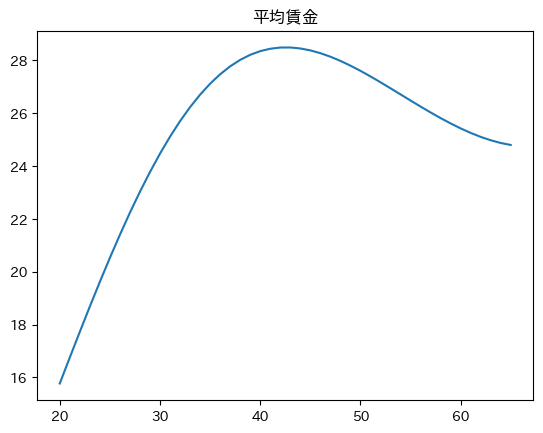

In [14]:
# 一時的ショック込みの賃金をwage_l
wage_average = []
wage_l = np.full(((t_retire-t_birth+1), n_quad), np.nan) #
coef_labor = param_dict["所得回帰係数"]["値"].values
for age in range(t_birth, t_retire+1):
    wage_ave = np.exp(np.dot(coef_labor, np.array([1, age, age**2, age**3])))
    wage_l[age-t_birth, :] = wage_ave * np.exp(v_quad * vol_y_t)
    wage_average.append(wage_ave)

wage_retire = rate_insub * wage_ave # 退職時の平均所得×所得代率(スカラー)
print(f"退職時後の年金{wage_retire}")
print(f"一時的ショック込みの給与:{wage_l.shape}")

# 退職時後の年金16.916264684224817
# 一時的ショック込みの給与:(46, 3)

# 賃金の永続的ショックが蓄積しないモデリング
grid_wage_p = np.full((n_quad, n_quad), 0.0) # (賃金の次元, 株式の次元)
for i_stock in range(n_quad):
    for i_wage in range(n_quad):
        grid_wage_p[i_wage, i_stock] = vol_y_p * (corr_stock * v_quad[i_stock] + np.sqrt(1-corr_stock**2) * v_quad[i_wage])

print(f"永続的ショック込みの掛け目:{grid_wage_p.shape}")
# 永続的ショック込みの掛け目:(3, 3)

plt.figure()
plt.plot(list(range(t_birth, t_retire+1)), wage_average)
plt.title('平均賃金')
plt.show()

# BACKWARD INDUCTION（退職期）
## 100歳から66歳まで実行

In [15]:
# 終端条件：t_death 歳での価値関数 = 効用関数
values_t = np.array([fn_utility(cash, gamma) for cash in grid_cash])

# 結果を保存するためのストレージ
years_after_retirement = t_death - (t_retire + 1)
values_retire = np.full((years_after_retirement, n_cash), np.nan)
policy_cons_retire = np.full((years_after_retirement, n_cash), np.nan)
policy_alpha_retire = np.full((years_after_retirement, n_cash), np.nan)

# メインループ- 99 歳から退職後 (66 歳)まで逆向きに
for idx_age, age in tqdm(enumerate(range(t_death-1, t_retire, -1))):
    # 相対年齢のインデックスを計算
    idx_age = age - t_retire - 1
    print(age, idx_age)
    
    # 次期の価値関数の補間
    fn_value_approx = interpolate.interp1d(
        grid_cash, values_t,
        kind='quadratic',#linear cubic quadratic
        bounds_error=False,
        fill_value=(values_t[0], values_t[-1]),
        #fill_value="extrapolate"
    )
    
    # 割引率の計算
    discount_rate = delta * rate_surv[age-t_birth]
    
    # 各キャッシュレベルに対する最適政策の計算
    for idx_cash in reversed(range(n_cash)):
        
        # 投資量の計算
        invest = grid_cash[idx_cash] - grid_cons
        
        # 効用関数コピー
        util = util_original.copy()
        
        # 有効・無効な消費を特定
        idx_valid_cons = np.where(invest >= 0)[0]
        idx_invalid_cons = np.where(invest < 0)[0]
        
        # 効用関数を調整
        util[idx_invalid_cons] = -np.inf
        invest[idx_invalid_cons] = 0
        
        # キャッシュレベルが安定している大きい順から計算していくと、前に計算した最適aとそんなに変わらない気がする
        # なので、aのグリッドもあたりを付けて計算することにする
        if (idx_cash <= n_cash - 5):
            idx_valid_alpha = np.where((grid_alpha <=grid_alpha[idx_best_alpha] +0.1)&(grid_alpha >=grid_alpha[idx_best_alpha] -0.05))[0]
        else:
            idx_valid_alpha = list(range(n_alpha))
            
        
        # 価値関数と最適政策の計算
        value_today, idx_best_cons, idx_best_alpha = environment_retire(
            util, wage_retire, invest, portret[idx_valid_alpha, :], w_quad, # aを絞ったportret
            fn_value_approx, discount_rate, idx_valid_cons
        )
        
        idx_best_alpha = idx_valid_alpha[idx_best_alpha] # 縮小aグリッド番号からグローバルなaグリッド番号へ変換
        
        # 結果の保存
        values_t[idx_cash] = value_today.copy()
        policy_cons_retire[idx_age, idx_cash] = grid_cons[idx_best_cons].copy()
        policy_alpha_retire[idx_age, idx_cash] = grid_alpha[idx_best_alpha].copy()
    
    # この年齢の値関数を保存
    values_retire[idx_age] = values_t.copy()

0it [00:00, ?it/s]

99 33
98 32
97 31
96 30
95 29
94 28
93 27
92 26
91 25
90 24
89 23
88 22
87 21
86 20
85 19
84 18
83 17
82 16
81 15
80 14
79 13
78 12
77 11
76 10
75 9
74 8
73 7
72 6
71 5
70 4
69 3
68 2
67 1
66 0


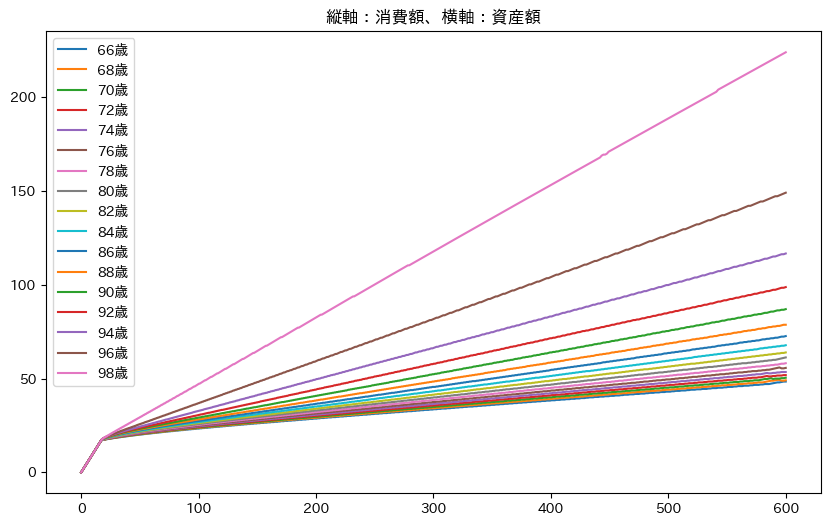

In [16]:
plt.figure(figsize=(10, 6))
for plot_idx_age1 in range(0, 34):
    if plot_idx_age1 % 2 == 0:
        plt.plot(grid_cash, policy_cons_retire[plot_idx_age1], label=f'{t_retire+1+plot_idx_age1}歳')
        plt.legend()
plt.title(f"縦軸：消費額、横軸：資産額")

plt.show()

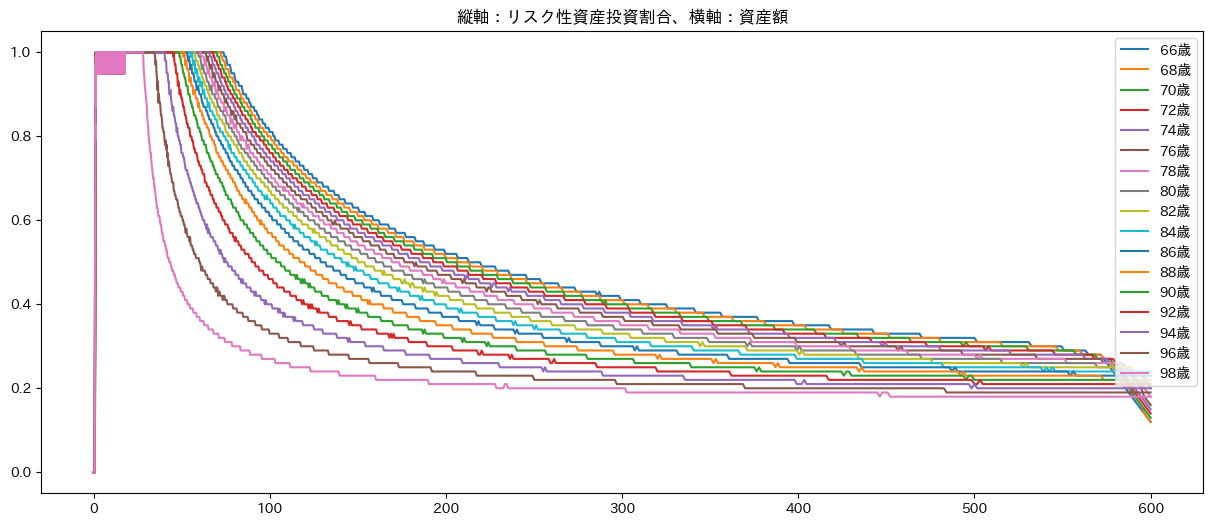

In [17]:
plt.figure(figsize=(15, 6))
for plot_idx_age1 in range(0, 34):
    if plot_idx_age1 % 2 == 0:
        plt.plot(grid_cash, policy_alpha_retire[plot_idx_age1], label=f'{t_retire+1+plot_idx_age1}歳')
plt.title(f"縦軸：リスク性資産投資割合、横軸：資産額")
plt.legend()
plt.show()

# 結果についての振り返り
マートン問題 (賃金無し)の解では、リスク性資産はα* = (μ-r)/(γσ^2) であり、人的資本を市場性のない安全資産として扱った場合の最適投資比
率は、α(X) = (μ-r)/(γσ^2) * (X/(X+PV)) ここでPVはリスクのない今後の所得の割引現在価値。

Marton's Ratio:0.16227838857560142


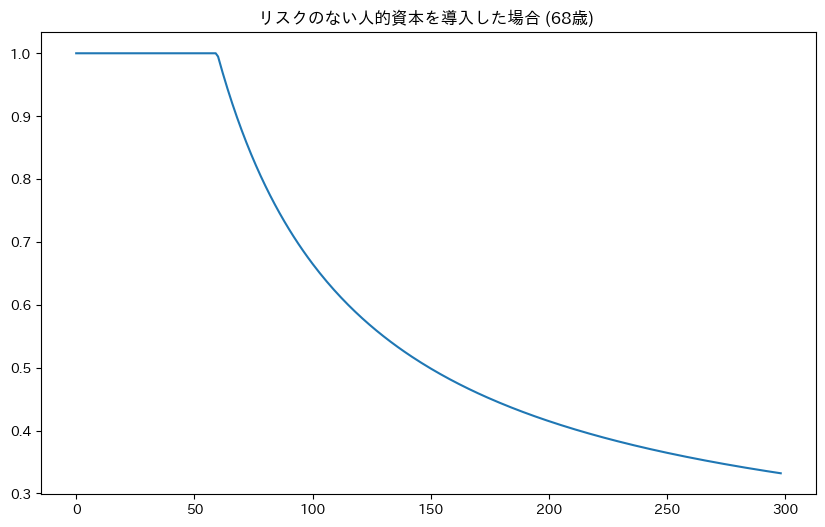

In [18]:
age = 68
alpha_marton = (expr-r_f)/(gamma*vol_r**2)
print(f"Marton's Ratio:{alpha_marton}")
disc_wage_retire = (rate_surv * delta * wage_retire)[t_retire-t_birth]

plt.figure(figsize=(10, 6))
plt.plot(np.minimum(1, alpha_marton*(1+ wage_retire*(1-delta**(t_death-age+1))/np.arange(1,300)/(1-delta))))
plt.title(f"リスクのない人的資本を導入した場合 ({age}歳) ")
plt.show()

# BACKWARD INDUCTION (現役)

In [19]:


# 記憶用の箱
years_working = t_retire - t_birth + 1 # 両端含含むから+1
values_work = np.full((years_working, n_cash), np.nan)
policy_cons_work = np.full((years_working, n_cash), np.nan)
policy_alpha_work = np.full((years_working, n_cash), np.nan)

values_t = values_retire[0].copy() # 引退期との引継ぎ。(n_cash,)

# 年齢FOR LOOP
for idx_age, age in tqdm(enumerate(reversed(range(t_birth, t_retire+1)))):# ←←←←←←←←←←←←←←←←
    # 相対年齢のインデックスを計算
    idx_age = years_working - idx_age - 1
    print(idx_age, age)
    
    # idx_age, age = 45, 65
    values_next = values_t.copy()
    
    # 次期の価値関数の補間
    fn_value_approx = interpolate.interp1d(
        grid_cash, values_t,
        kind='quadratic',#cubic linear quadratic
        bounds_error=False,
        fill_value=(values_t[0], values_t[-1])
        #fill_value="extrapolate"
    )
    
    values_t = np.full(n_cash, np.nan) # 関数近似が終わったら上書きOK
    policy_cons = np.full(n_cash, np.nan)
    policy_alpha = np.full(n_cash, np.nan)
    
    # ここからForループ (キャッシュ水準)
    # あるキャッシュ水準 (グリッド)のときに、消費額と投資比率の組の決定を最適化で求める
    for idx_cash in reversed(range(n_cash)): # ←←←←←←←←←←←←←←←←←キャッシュLOOP★
        # idx_cash = 4
        # 今期の投資量(invest)のグリッドを計算。invest が負になる場合は今期の効用は負の無限大
        invest = grid_cash[idx_cash] * np.ones(n_cons) - grid_cons # a
        util = util_original.copy() # util_original は変えない
        idx_valid_cons = np.where(invest >= 0)[0] # 投資額が非負のインデックス。適切消費の消費インデックス
        idx_invalid_cons = np.where(invest < 0)[0] # 投資額が負のインデックス。つまり消費しすぎなので、消費
        # インデックス
        util[idx_invalid_cons] = -np.infty # 持っているキャッシュ以上に使うことは許さない
        invest[idx_invalid_cons] = 0 # 無効な投資をゼロに設定
        
        # キャッシュレベルが安定している大きい順から計算していくと、前に計算した最適aとそんなに変わらない気
        # がする
        # なので、aのグリッドもあたりを付けて計算することにする
        if (idx_cash <= n_cash - 2):
            idx_valid_alpha = np.where((grid_alpha <=grid_alpha[idx_best_alpha] +0.1)&(grid_alpha >=grid_alpha[idx_best_alpha] -0.05))[0]
        else:
            idx_valid_alpha = list(range(n_alpha))
        
        # 今期の価値関数の計算 (ガウス・エルミートも計算済み)
        discount_rate = delta * rate_surv[idx_age]
        wage_l_t = wage_l[idx_age] # age 歳のときの一時ショック込みの所得 wage_l_t.shape==(n_quad,)
        
        value_today, idx_best_cons, idx_best_alpha = environment_work(
            util, wage_l_t, grid_wage_p, invest, portret[idx_valid_alpha, :],
            w_quad, fn_value_approx, discount_rate,
            idx_valid_cons
        )
        
        idx_best_alpha = idx_valid_alpha[idx_best_alpha] # 縮小aグリッド番号からグローバルなaグリッド番号へ変換
        
        # 結果の保存
        values_t[idx_cash] = value_today
        policy_cons_work[idx_age, idx_cash] = grid_cons[idx_best_cons]
        policy_alpha_work[idx_age, idx_cash] = grid_alpha[idx_best_alpha]
    
    # この年齢の値関数を保存
    values_work[idx_age] = values_t.copy()

0it [00:00, ?it/s]

45 65
44 64
43 63
42 62
41 61
40 60
39 59
38 58
37 57
36 56
35 55
34 54
33 53
32 52
31 51
30 50
29 49
28 48
27 47
26 46
25 45
24 44
23 43
22 42
21 41
20 40
19 39
18 38
17 37
16 36
15 35
14 34
13 33
12 32
11 31
10 30
9 29
8 28
7 27
6 26
5 25
4 24
3 23
2 22
1 21
0 20


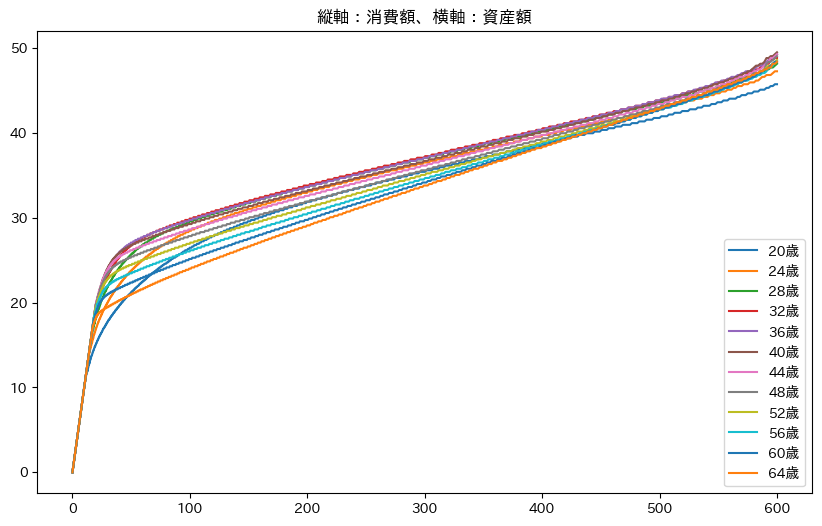

In [20]:
plt.figure(figsize=(10, 6))
for plot_idx_age1 in range(0, 46):
    if plot_idx_age1 % 4 == 0:
        plt.plot(grid_cash, policy_cons_work[plot_idx_age1], label=f'{t_birth+plot_idx_age1}歳')
plt.title(f"縦軸：消費額、横軸：資産額")
plt.legend()
plt.show()

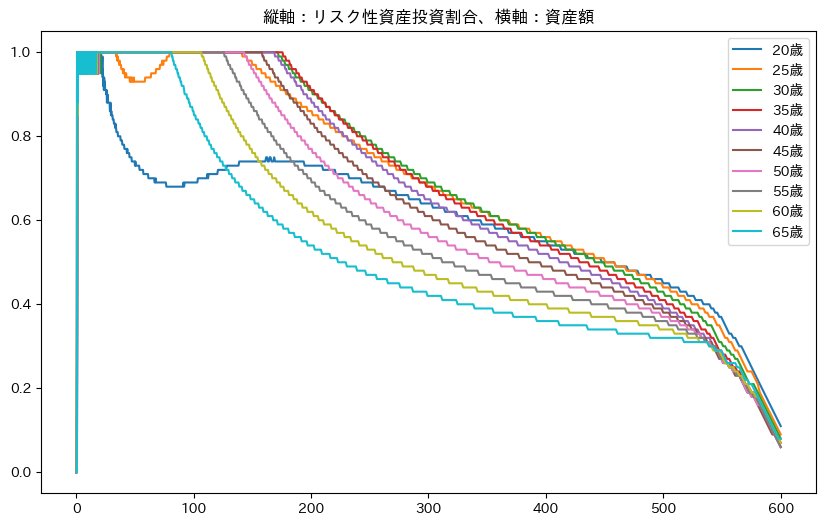

In [21]:
plt.figure(figsize=(10, 6))
for plot_idx_age1 in range(0, 46):#range(0, 46)
    if plot_idx_age1 % 5 == 0:
        plt.plot(grid_cash, policy_alpha_work[plot_idx_age1], label=f'{t_birth+plot_idx_age1}歳')
plt.title(f"縦軸：リスク性資産投資割合、横軸：資産額")
plt.legend()
plt.show()

/tmp/ipykernel_2364/1520824417.py:4: RuntimeWarning: invalid value encountered in divide
  plt.plot(grid_cash, policy_cons_work[plot_idx_age1]/grid_cash, label=f'{t_birth+plot_idx_age1}歳')


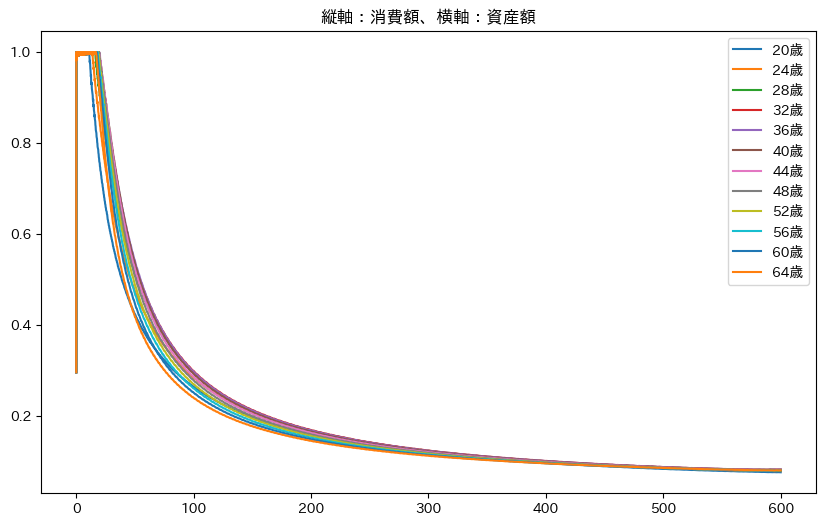

In [22]:
plt.figure(figsize=(10, 6))
for plot_idx_age1 in range(0, 46):
    if plot_idx_age1 % 4 == 0:
        plt.plot(grid_cash, policy_cons_work[plot_idx_age1]/grid_cash, label=f'{t_birth+plot_idx_age1}歳')
plt.title(f"縦軸：消費額、横軸：資産額")
plt.legend()
plt.show()

# 退職期と勤労期のデータの結合

In [23]:
# 退職期と勤労期のデータの結合
policy_alpha = np.vstack([policy_alpha_work, policy_alpha_retire])
policy_cons = np.vstack([policy_cons_work, policy_cons_retire])
values = np.vstack([values_work, values_retire])
print(policy_alpha.shape) # ->(80, 401)
print(policy_cons.shape) # ->(80, 401)
print(values.shape) # ->(80, 401)

(80, 1001)
(80, 1001)
(80, 1001)


# 描画

In [24]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact, IntSlider

ages = np.arange(t_birth, t_birth + policy_cons.shape[0]) # 年齢のリスト
cash_plot_area = 311

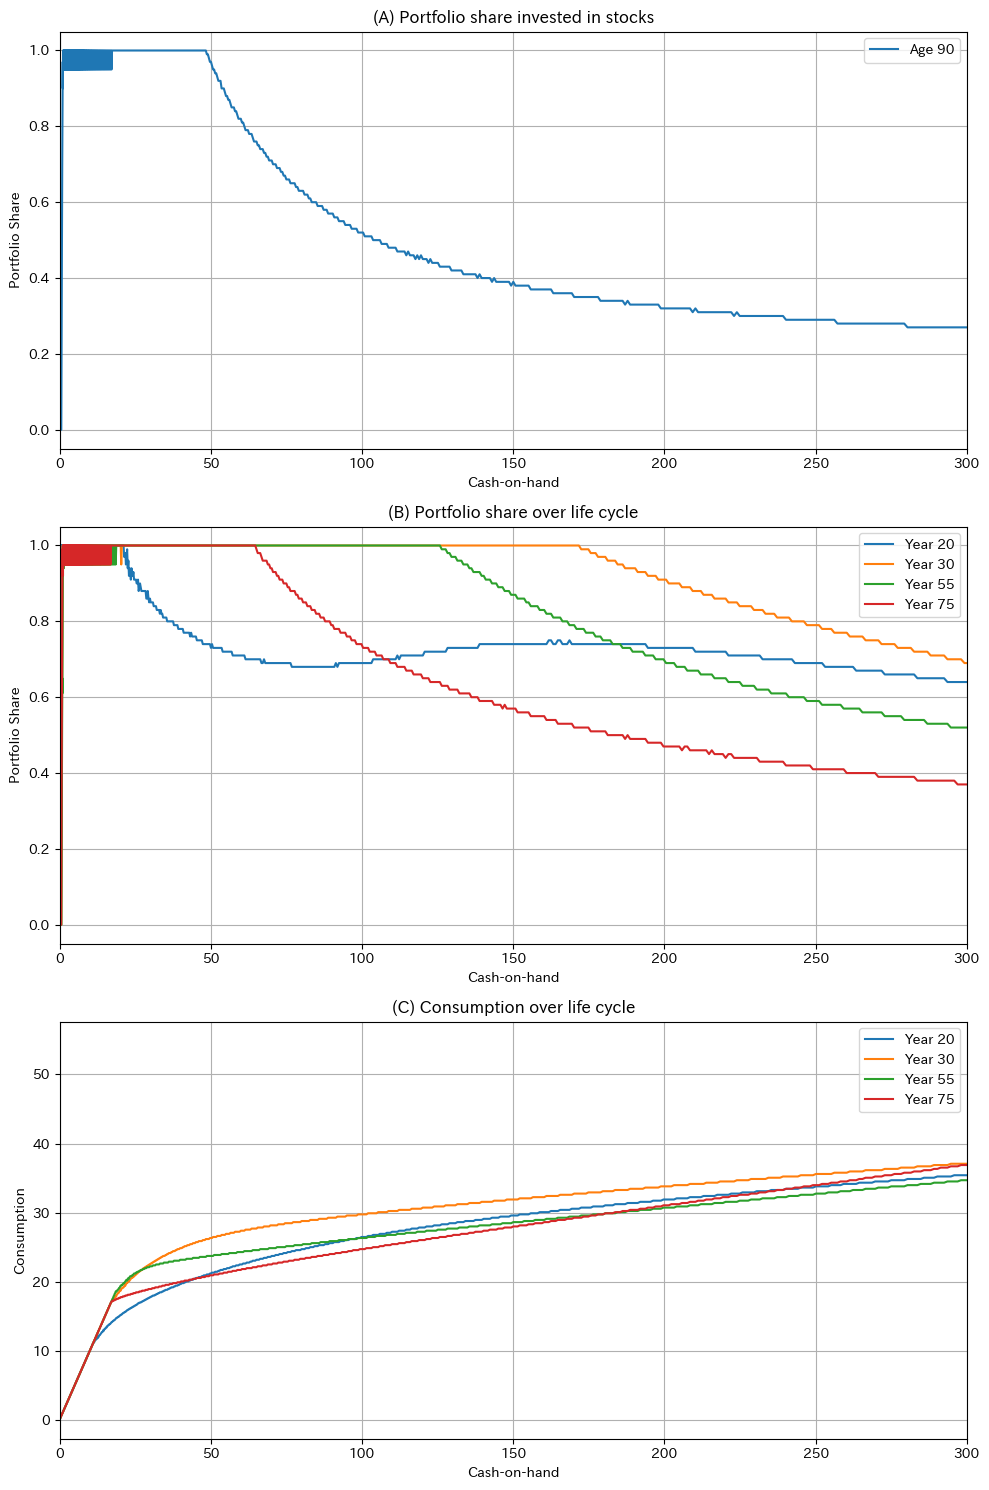

In [25]:

# 年齢の範囲
t_birth = 20
ages = np.arange(t_birth, t_birth + policy_cons.shape[0]) # 年齢のリスト

# 選択する年齢 (例: 20歳、30歳、55歳、75歳)
selected_ages = [20, 30, 55, 75]

# サブプロットの作成
fig, axs = plt.subplots(3, 1, figsize=(10, 15)) # 3行1列のサブプロット

# (A) Portfolio share invested in stocks

idx = 90 - t_birth # 年齢に対応するインデックス
axs[0].plot(grid_cash, policy_alpha[idx], label=f'Age {90}')
axs[0].set_title('(A) Portfolio share invested in stocks')
axs[0].set_xlabel('Cash-on-hand')
axs[0].set_ylabel('Portfolio Share')
axs[0].legend(loc='best')
axs[0].set_xlim(0, 300) # 横軸を0～300に制限
axs[0].grid(True)

# (B) Portfolio share invested in stocks at different stages
for age in selected_ages:
    idx = age - t_birth # 年齢に対応するインデックス
    axs[1].plot(grid_cash, policy_alpha[idx], label=f'Year {age}')
axs[1].set_title('(B) Portfolio share over life cycle')
axs[1].set_xlabel('Cash-on-hand')
axs[1].set_ylabel('Portfolio Share')
axs[1].legend(loc='best')
axs[1].set_xlim(0, 300) # 横軸を0～300に制限
axs[1].grid(True)

# (C) Consumption at different stages
for age in selected_ages:
    idx = age - t_birth # 年齢に対応するインデックス
    axs[2].plot(grid_cash, policy_cons[idx], label=f'Year {age}')
axs[2].set_title('(C) Consumption over life cycle')
axs[2].set_xlabel('Cash-on-hand')
axs[2].set_ylabel('Consumption')
axs[2].legend(loc='best')
axs[2].set_xlim(0, 300) # 横軸を0～300に制限
axs[2].grid(True)

# グラフのレイアウト調整
plt.tight_layout()

# グラフを画像として保存
#plt.savefig('output/v7/my_figure2.png', dpi=300, bbox_inches='tight') # ファイル名を指定して保存

# グラフの表示
plt.tight_layout()
plt.show()

In [28]:
# 結果の保存
from datetime import datetime

# 現在の日付を取得
today = datetime.now()

# YYYYMMDD形式で出力
formatted_date = today.strftime('%Y%m%d')
print(formatted_date)

# 保存
save_dict = dict()

parameters = {
    "t_birth": t_birth,
    "t_retire": t_retire,
    "t_death": t_death,
    "n_quad": n_quad,
    "n_alpha": n_alpha,
    "n_cons": n_cons,
    "n_cash": n_cash,
    "delta": delta,
    "gamma": gamma,
    "r_f": r_f,
    "vol_r": vol_r,
    "expr": expr,
    "reg_coef": reg_coef,
    "rate_insub": rate_insub,
    "vol_y_t": vol_y_t,
    "vol_y_p": vol_y_p,
    "max_cash": max_cash,
    "min_cash": min_cash,
    "max_cons": max_cons,
    "min_cons": min_cons,
    "maliar_theta": maliar_theta,
    "w_quad": w_quad,
    "v_quad": v_quad,
    "rate_surv": rate_surv,
    "grid_alpha": grid_alpha, 
    "grid_cash": grid_cash,
    "grid_cons": grid_cons,
    "grid_ret": grid_ret, 
    "portret": portret,
    "coef_labor": coef_labor,
    "wage_average":wage_average,
    "wage_retire":wage_retire,
    "grid_wage_p":grid_wage_p
}

save_dict["parameters"] = parameters
save_dict["data"] = dict()
save_dict["data"]["values"] = values
save_dict["data"]["policy_cons"] = policy_cons
save_dict["data"]["policy_alpha"] = policy_alpha

with open(f'output/save_dict_{formatted_date}.pkl', 'wb') as f:
    pickle.dump(save_dict, f)

20250607
